# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)


if "__file__" not in dir():
    %run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names


# Decoding


Train one decoder and use it to decode velocity in other animals.  
The logic follows:  
CCA gives us: $X_1A\cong X_2B$  
Then: $X_1 \cong X_2BA^{-1}$  
So, we can train a decoder on $X_1$ and, then align any $X_2$ to $X_1$ to get $A$ and $B$.  
The same decoder should work on $X_2BA^{-1}$ as input.

Now... Same as above, for different animals

# Across animal decoding

## With alignment 

In [2]:
if "__file__" not in dir():
    full_list = []
    for animal, sessionList in GoodDataList[defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list.append((animal,sessionList))
    full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

    # load the DFs
    warnings.filterwarnings("ignore")
    allDFs = []
    for animal, session in full_list:
        path = root/animal/session
        allDFs.append(defs.prep_general(dt.load_pyal_data(path)))
    warnings.filterwarnings("default")


pairIndex_uni = []
for i, (animal1,session1) in enumerate(full_list):
    pairIndex_uni.append((i,[]))
    for j, (animal2,session2) in enumerate(full_list):
        if animal1 == animal2: continue
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue
        pairIndex_uni[-1][1].append(j)

In [5]:
warnings.filterwarnings("ignore")
reg_scores_across = []
for id1, testList in pairIndex_uni:
    AllData, AllVel = defs.get_data_array_and_vel([allDFs[id1]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
    AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
    AllData1 = AllData[0,...]
    AllVel1 = AllVel[0,...]
    X_ = AllData1.reshape((-1,AllData1.shape[-1]))
    AllVel1 = AllVel1.reshape((-1,2))
    Y_train_x,Y_train_y = AllVel1.T
    decode_x, decode_y = LinearRegression(), LinearRegression()
    decode_x.fit(X_, Y_train_x)
    decode_y.fit(X_, Y_train_y)
    for testId in testList:
        AllData, AllVel = defs.get_data_array_and_vel([allDFs[testId]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        
        AllData2 = AllData[0,...]
        AllVel2 = AllVel[0,...]
        # size matching
        *_,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        X1 = AllData1[:,:n_trial,:n_time,:n_comp].reshape((-1,n_comp))
        X2 = AllData2[:,:n_trial,:n_time,:n_comp].reshape((-1,n_comp))
        AllVel2 = AllVel2[:,:n_trial,:n_time,:].reshape((-1,2))

        # alignment the decoder
        A,B,*_ = dt.canoncorr(X1, X2, fullReturn=True)
        X2_aligned = X2 @ B @ linalg.inv(A) 

        # test the decoder
        Y_test_x,Y_test_y = AllVel2.T
        x_score = defs.custom_r2_func(Y_test_x, decode_x.predict(X2_aligned))
        y_score = defs.custom_r2_func(Y_test_y, decode_y.predict(X2_aligned))
        reg_scores_across.append((id1,testId,(x_score,y_score)))
warnings.filterwarnings("default")

pop_score_uni = []
for _,_,scores in reg_scores_across:
    pop_score_uni.append(np.mean(scores))
pop_score_uni = np.array(pop_score_uni)

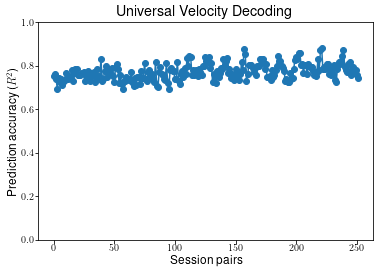

In [6]:
if "__file__" not in dir():
    _,ax = plt.subplots()
    ax.plot(pop_score_uni,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs')
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_title('Universal Velocity Decoding')